# Pendahuluan
Nurul Jannah (personal.nuruljannah@gmail.com)

Berikut Pemodelan Jaringan Syaraf Tiruan untuk Klasifikasi Gambar yang saya susun untuk memenuhi syarat lulus kelas 'Belajar Pengembangan Machine Learning'.

# Mengakses Dataset

Untuk mengunduh dataset dari kaggle maka pertama-tama kita perlu menghubungkan Google Colaboratory dengan Kaggle menggunakan Kaggle API.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kynuuu","key":"bb4723de81bdc3c6bbddaf30ec71d7c8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Mengunduh Dataset

Dataset yang akan digunakan pada pemodelan machine learning untuk klasifikasi gambar adalah Female and Male Eyes. Dataset ini terdiri dari ~11525 data dengan rincian 5202 data gambar mata wanita dan 6323 data gambar mata pria.

In [5]:
!kaggle datasets download -d pavelbiz/eyes-rtte

 92% 37.0M/40.4M [00:00<00:00, 73.1MB/s]
100% 40.4M/40.4M [00:00<00:00, 135MB/s] 


# Import Modul
Pada bagian ini akan di import beberapa modul yang diperlukan dalam pemodelan jaringan syaraf tiruan untuk klasifikasi gambar menggunakan Tensorflow.

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mengekstrak file zip

Mengekstrak dataset yang telah diunduh sebelumnya.

In [6]:
import os
import zipfile

local_zip = '/content/eyes-rtte.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/eyes-dataset')
zip_ref.close()

In [7]:
base_dir = '/content/eyes-dataset'
os.listdir(base_dir)

['femaleeyes', 'maleeyes']

In [22]:
# Melihat jumlah gambar pada setiap direktori

print('Total Female Eyes Images: ', len(os.listdir('/content/eyes-dataset/femaleeyes')))
print('Total Male Eyes Images: ', len(os.listdir('/content/eyes-dataset/maleeyes')))

Total Female Eyes Images:  5202
Total Male Eyes Images:  6323


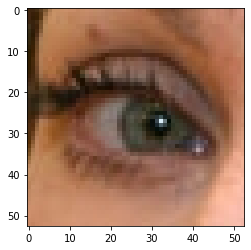

In [23]:
# Melihat contoh gambar

from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = image.load_img('/content/eyes-dataset/femaleeyes/1.jpg')
imgplot = plt.imshow(img)

# Membuat Objek ImageDataGenerator
Pada tahap ini akan dibuat objek ImageDataGenerator untuk data training dan data validation. Tujuan dari pembuatan objek ini adalah untuk mempersiapkan data latih dan data validasi yang akan diberikan ke model.

Kode di bawah menunjukkan proses augmentasi gambar pada setiap sampel di dataset. Hal ini bertujuan untuk memperkaya dataset dengan menciptakan data-data baru dari data yang telah ada. Selain itu, pada tahap ini dilakukan pemisahan dataset menjadi data training dan data validation dengan rasio 80% untuk data training dan 20% untuk data validation.

In [8]:
train_datagen = ImageDataGenerator(
                  rescale = 1./255,
                  rotation_range = 20,
                  horizontal_flip = True,
                  vertical_flip = True,
                  shear_range = 0.2,
                  fill_mode = 'nearest',
                  validation_split = 0.2)

In [9]:
train_generator = train_datagen.flow_from_directory(
                    base_dir,
                    target_size = (150,150),
                    batch_size = 32,
                    shuffle = True,
                    subset ='training',
                    class_mode = 'binary')

val_generator = train_datagen.flow_from_directory(
                    base_dir,
                    target_size = (150,150),
                    batch_size = 32,
                    shuffle = True,
                    subset = 'validation',
                    class_mode = 'binary')

Found 9221 images belonging to 2 classes.
Found 2304 images belonging to 2 classes.


# Membangun Arsitektur CNN
Pada tahap ini akan dibuat suatu model Sequential dengan memanfaatkan algoritma CNN.

In [10]:
model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),                                    
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),                                    
        tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),                            
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])

In [11]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

Pada pemodelan ini digunakan fungsi callback untuk memberi tahu model agar berhenti melakukan pelatihan ketika akurasi data training dan validation telah mencapai 92%.

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .92 and logs.get('val_accuracy') > .92:
      self.model.stop_training = True
    
callbacks = myCallback()

Terlihat di bawah ini model berhasil menghentikan pelatihan ketika data training dan validation telah mencapai akurasi 92% pada epoch ke 165 dari 300. Artinya kita telah menghemat waktu eksekusi 135 epoch.

In [13]:
# Melatih model

history = model.fit(
          train_generator,
          steps_per_epoch = 25,
          epochs = 300,
          validation_data = val_generator,
          validation_steps = 5,
          verbose = 2,
          callbacks=[callbacks])

Epoch 1/300
25/25 - 37s - loss: 0.7234 - accuracy: 0.5038 - val_loss: 0.6954 - val_accuracy: 0.4062
Epoch 2/300
25/25 - 5s - loss: 0.6833 - accuracy: 0.5713 - val_loss: 0.6704 - val_accuracy: 0.6187
Epoch 3/300
25/25 - 5s - loss: 0.6872 - accuracy: 0.5951 - val_loss: 0.6844 - val_accuracy: 0.5437
Epoch 4/300
25/25 - 5s - loss: 0.6459 - accuracy: 0.6400 - val_loss: 0.6018 - val_accuracy: 0.7437
Epoch 5/300
25/25 - 5s - loss: 0.5748 - accuracy: 0.7100 - val_loss: 0.5792 - val_accuracy: 0.6812
Epoch 6/300
25/25 - 5s - loss: 0.5869 - accuracy: 0.7000 - val_loss: 0.4979 - val_accuracy: 0.7688
Epoch 7/300
25/25 - 5s - loss: 0.5569 - accuracy: 0.7337 - val_loss: 0.5392 - val_accuracy: 0.7063
Epoch 8/300
25/25 - 5s - loss: 0.5061 - accuracy: 0.7650 - val_loss: 0.5684 - val_accuracy: 0.7250
Epoch 9/300
25/25 - 5s - loss: 0.4669 - accuracy: 0.7725 - val_loss: 0.3269 - val_accuracy: 0.9062
Epoch 10/300
25/25 - 5s - loss: 0.5000 - accuracy: 0.7513 - val_loss: 0.5236 - val_accuracy: 0.7688
Epoch 11

# Prediksi Gambar

Memprediksi gambar menggunakan model yang telah dibuat sebelumnya. Adapun gambar yang diuji adalah gambar yang diperoleh dari Google.

Saving fe.jpg to fe.jpg
fe.jpg
female eyes


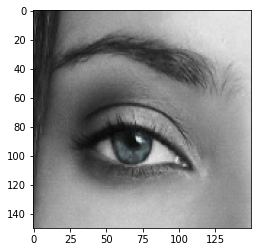

In [24]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  
  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  if classes==0:
    print('female eyes')
  else:
    print('male eyes')

# Plot Loss dan Akurasi

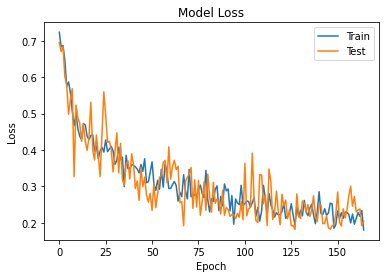

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

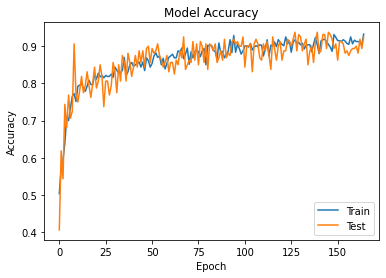

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Save Model to TF-Lite

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphfvjeyod/assets
